# Basic Neural Net from scratch
## along fast.ai tutorial

https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch

## import data

In [1]:
import pandas as pd

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    df = pd.read_csv("nnbasic-btc-data.csv", index_col=0).reset_index(drop=True)
else:
    df = pd.read_csv("nnbasic-btc-data.csv", index_col=0).reset_index(drop=True)


print(df.shape)
df.head(3)

(11713, 44)


,time_s3,open_s3,high_s3,low_s3,close_s3,vol_s3,log_open_s3,log_high_s3,log_low_s3,log_close_s3,...,open,high,low,close,vol,log_open,log_high,log_low,log_close,norm_vol
0,2023.06.01 00:00,27103.1,27108.1,27080.6,27096.9,386.675,10.207403,10.207588,10.206573,10.207175,...,27054.9,27084.0,27054.8,27084.0,218.143,10.205623,10.206698,10.205620,10.206698,0.003386
1,2023.06.01 00:15,27096.9,27096.9,27036.7,27047.0,408.680,10.207175,10.207175,10.204950,10.205331,...,27084.0,27113.9,27073.5,27100.0,329.412,10.206698,10.207802,10.206311,10.207289,0.005114
2,2023.06.01 00:30,27047.0,27077.4,27041.0,27054.9,275.080,10.205331,10.206455,10.205110,10.205623,...,27100.0,27159.0,27100.0,27142.4,979.655,10.207289,10.209464,10.207289,10.208852,0.015208


In [2]:
# do not use the time columns 

df_train = df.filter(items = ['log_open_s3', 'log_high_s3', 'log_low_s3', 'log_close_s3', 'norm_vol_s3',
       'log_open_s2', 'log_high_s2', 'log_low_s2', 'log_close_s2', 'norm_vol_s2',
       'log_open_s1', 'log_high_s1', 'log_low_s1', 'log_close_s1', 'norm_s1', 
       'log_open', 'log_high', 'log_low', 'log_close', 'norm_vol']).dropna()
print(df_train.shape)
df_train.head(3)

(11713, 19)


,log_open_s3,log_high_s3,log_low_s3,log_close_s3,norm_vol_s3,log_open_s2,log_high_s2,log_low_s2,log_close_s2,norm_vol_s2,log_open_s1,log_high_s1,log_low_s1,log_close_s1,log_open,log_high,log_low,log_close,norm_vol
0,10.207403,10.207588,10.206573,10.207175,0.006003,10.207175,10.207175,10.20495,10.205331,0.006344,10.205331,10.206455,10.205110,10.205623,10.205623,10.206698,10.205620,10.206698,0.003386
1,10.207175,10.207175,10.204950,10.205331,0.006344,10.205331,10.206455,10.20511,10.205623,0.004270,10.205623,10.206698,10.205620,10.206698,10.206698,10.207802,10.206311,10.207289,0.005114
2,10.205331,10.206455,10.205110,10.205623,0.004270,10.205623,10.206698,10.20562,10.206698,0.003386,10.206698,10.207802,10.206311,10.207289,10.207289,10.209464,10.207289,10.208852,0.015208


### hist plots to check log normalization

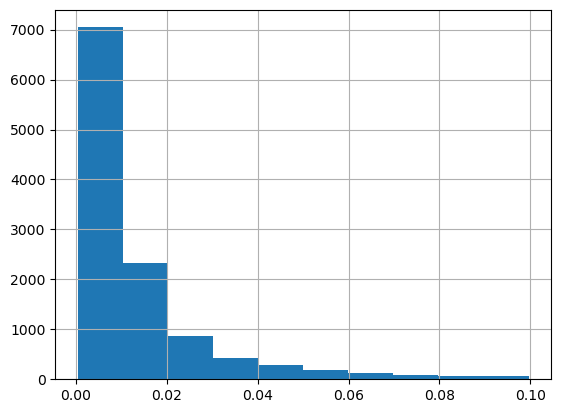

In [3]:
#df_train['norm_vol'].where(df_train.vol < 10000).hist();
df_train['norm_vol'].where(df_train.norm_vol < 0.1).hist();

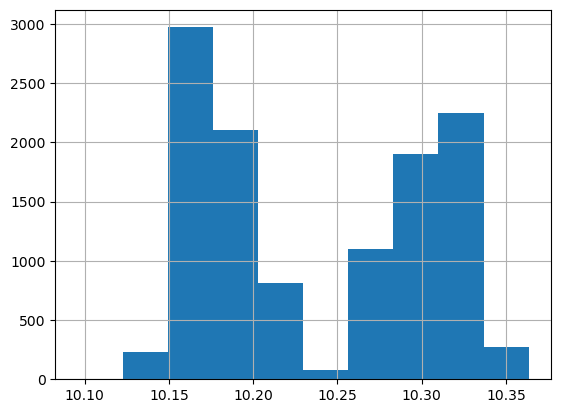

In [4]:
df_train['log_open'].hist();

## dep, indep, weights and bias

In this setting we will just try to predict the high value based on the previous three candles. The results will likely not be good since point predictions are tricky.

In [5]:
import torch
from torch import tensor

t_dep = tensor(df_train['log_high'].values, dtype=torch.float)
print(t_dep.shape) # 1 D tensor
t_dep

torch.Size([11713])


tensor([10.2067, 10.2078, 10.2095,  ..., 10.2057, 10.2059, 10.2061])

All variables are used instead of the high value which is the dependend value.

In [6]:
t_indep = tensor(df_train.loc[:, df_train.columns != "log_high"].values, dtype=torch.float)

t_indep.shape # 2 D tensor > rows with observations and columns with features

torch.Size([11713, 18])

The number of features needs to be the same as the lenght of the weights, because they will be multiplicated.

In [7]:
import math

n,c = t_indep.shape

# "We are initializing the weights here with Xavier initialisation (by multiplying n random weights with 1/sqrt(n))."
weights = torch.randn(c) / math.sqrt(n)
weights.requires_grad_()
bias = torch.zeros(n, requires_grad=True)
weights.shape

torch.Size([18])

In [8]:
(t_indep*weights).sum(axis=1).shape #checking the axis sum

torch.Size([11713])

## making the first prediction

Since we are making a linear classifier the formula for yhat or the predictions is the sum of the products of coefficients and observations. 

In other words: 

$ y = x_0 \times b_0 + x_1 \times b_1 $

where $x_0$ is the first vector of observations (=features) and $b_0$ is the first coefficient.

and then is $y$ the vector with the predictions the same length as the data frame, so this formula can be read "rowwise".

In [9]:
preds = (t_indep*weights).sum(axis=1)
print(preds.shape) # 1d vector of predictions
preds[0:3] # the first three predictions of n

torch.Size([11713])


tensor([0.0565, 0.0565, 0.0568], grad_fn=<SliceBackward0>)

In [10]:
# quick check for first row: 

print(f"indep[0]: {t_indep[0]}")
print(f"\n weights: {weights}")
print("\n first entry of Indep * weights: \n",t_indep[0][0]*weights[0])
print("\n Indep * weights : \n",t_indep[0]*weights)
print("\n sum of Indep * weights = 1d vector: \n", (t_indep*weights).sum(axis=1) ) #axis=1 is along the colums


indep[0]: tensor([1.0207e+01, 1.0208e+01, 1.0207e+01, 1.0207e+01, 6.0028e-03, 1.0207e+01,
        1.0207e+01, 1.0205e+01, 1.0205e+01, 6.3444e-03, 1.0205e+01, 1.0206e+01,
        1.0205e+01, 1.0206e+01, 1.0206e+01, 1.0206e+01, 1.0207e+01, 3.3865e-03])

 weights: tensor([-0.0127, -0.0110,  0.0020, -0.0134, -0.0124,  0.0056,  0.0134,  0.0070,
        -0.0021,  0.0042, -0.0012, -0.0005, -0.0056,  0.0083,  0.0062,  0.0162,
        -0.0066,  0.0151], requires_grad=True)

 first entry of Indep * weights: 
 tensor(-0.1293, grad_fn=<MulBackward0>)

 Indep * weights : 
 tensor([-1.2933e-01, -1.1212e-01,  2.0182e-02, -1.3697e-01, -7.4239e-05,
         5.7013e-02,  1.3672e-01,  7.1254e-02, -2.1332e-02,  2.6561e-05,
        -1.1969e-02, -5.3569e-03, -5.7542e-02,  8.5025e-02,  6.3092e-02,
         1.6515e-01, -6.7318e-02,  5.1026e-05], grad_fn=<MulBackward0>)

 sum of Indep * weights = 1d vector: 
 tensor([0.0565, 0.0565, 0.0568,  ..., 0.0565, 0.0566, 0.0566],
       grad_fn=<SumBackward1>)


## loss: mean absolute error

In [11]:
loss_mae_manual = torch.abs(preds-t_dep).mean()
print(loss_mae_manual.shape)
loss_mae_manual

torch.Size([])


tensor(10.1820, grad_fn=<MeanBackward0>)

In [12]:
# initialise coeffs and define the independent variable 
t_indep*weights

# define it as a function 
def calc_preds(weights, indeps): return (indeps*weights).sum(axis=1)
    
preds = (t_indep*weights).sum(axis=1) #along columns, therefore length n vector

In [13]:
# define the loss function

# herer it is mean absolute error
loss = torch.abs(preds-t_dep).mean()

# define it in a function
def calc_loss(dep, indep, weights): return torch.abs( (indep*weights).sum(axis=1) - dep).mean()

In [14]:
print(calc_preds(t_indep,weights))
print(calc_loss(t_dep,t_indep,weights))

tensor([0.0565, 0.0565, 0.0568,  ..., 0.0565, 0.0566, 0.0566],
       grad_fn=<SumBackward1>)
tensor(10.1820, grad_fn=<MeanBackward0>)


## sidebar: cross entropy loss via pytorch functional

In [15]:
import torch.nn.functional as F
loss_ce = F.cross_entropy(preds, t_dep)
loss_mae = F.l1_loss(preds, t_dep)
loss_mae = F.mse_loss(preds, t_dep)

print("mean absolute error:",loss_mae)
print("mean squared error:",loss_mae)
print("cross entropy:",loss_ce)

mean absolute error: tensor(103.6769, grad_fn=<MseLossBackward0>)
mean squared error: tensor(103.6769, grad_fn=<MseLossBackward0>)
cross entropy: tensor(1123529., grad_fn=<DivBackward1>)


## gradients & learning rate

In [16]:
loss = calc_loss(t_dep, t_indep,weights)
loss.backward(retain_graph=True)
weights.grad

tensor([-10.2377, -10.2388, -10.2366, -10.2377,  -0.0172, -10.2377, -10.2388,
        -10.2366, -10.2377,  -0.0172, -10.2377, -10.2388, -10.2366, -10.2377,
        -10.2377, -10.2366, -10.2377,  -0.0172])

In [17]:
# if done twice or more: the gradients are added together
loss.backward(retain_graph=True)
print(weights.grad)

tensor([-20.4755, -20.4776, -20.4732, -20.4755,  -0.0345, -20.4755, -20.4776,
        -20.4732, -20.4755,  -0.0345, -20.4755, -20.4776, -20.4732, -20.4755,
        -20.4755, -20.4732, -20.4755,  -0.0345])


## gradient descent step

In [18]:
# loss = calc_loss(coeffs, t_indep, t_dep) # already done 
loss.backward(retain_graph=True) 
with torch.no_grad():
    print(weights.grad)
    weights.sub_(weights.grad * 0.1) # subtract inplace gradients*learning_rate > i.e. move one step 
    weights.grad.zero_() 
    print(calc_loss(t_dep, t_indep,weights))

tensor([-30.7132, -30.7163, -30.7099, -30.7132,  -0.0517, -30.7132, -30.7163,
        -30.7099, -30.7132,  -0.0517, -30.7132, -30.7163, -30.7099, -30.7132,
        -30.7132, -30.7099, -30.7132,  -0.0517])
tensor(461.4607)


**by adding the steps _grad_zero_ and recalculating the _loss_ the weights stay the same when executing this cell multiple times**

## putting everything in a function

What does one iteration need?

It proceeds in the following order: 
- dependent and independent variables are given
- epochs and learning rate are given
- weights and bias are initialized
- loss is calculated
- gradients are calculated
- one step is moved: $weights - (gradients*learning\ rate)$

In [22]:
#reminder: 
def calc_loss(dep, indep, weights): return torch.abs( (indep*weights).sum(axis=1) - dep).mean()

def one_epoch(dep, indep,lr):
    
    # "We are initializing the weights here with Xavier initialisation (by multiplying n random weights with 1/sqrt(n))."
    n,c = indep.shape
    weights = (torch.randn(c) / math.sqrt(n)).requires_grad_()

    # start with loss
    loss = calc_loss(dep, indep, weights)

    # calc gradients
    loss.backward(retain_graph=True) 

    # update weights = move one step 
    with torch.no_grad():
        
        # subtract inplace gradients*learning_rate 
        weights.sub_(weights.grad * lr) 

        # zeroing gradients
        weights.grad.zero_() 

        #printing loss
        print(f"{loss:.3f}", end="; ")
    return torch.sigmoid(weights)

In [33]:
def train_model(dep,indep,epochs=50, lr=0.01):
    torch.manual_seed(420)
    for i in range(epochs): one_epoch(dep,indep, lr=lr)
    return weights

In [34]:
train_model(t_dep,t_indep)

10.423; 10.620; 10.535; 9.832; 10.153; 10.557; 10.240; 10.014; 10.437; 10.392; 10.011; 10.309; 9.939; 10.462; 10.275; 10.095; 10.464; 10.087; 10.392; 10.751; 10.325; 9.680; 9.445; 10.306; 10.705; 9.711; 10.638; 9.727; 9.830; 9.738; 10.553; 10.246; 9.897; 9.818; 10.050; 10.110; 11.080; 10.846; 10.399; 9.662; 10.190; 9.844; 9.950; 10.374; 9.866; 9.776; 10.345; 10.377; 9.877; 10.396; 

tensor([ 3.0587,  3.0607,  3.0730,  3.0579, -0.0072,  3.0769,  3.0850,  3.0780,
         3.0692,  0.0094,  3.0701,  3.0711,  3.0653,  3.0797,  3.0775,  3.0872,
         3.0647,  0.0202], requires_grad=True)

## next steps: done! 

 - figure out when and how to use backward() and require_grad
 - put the pieces togehter: calc preds > calc loss > get gradients > subtract gradients*learningrate with preds

Note on gradients: \n
My current understand is that you need to specify the tensor of where to calculate the gradients on, to access them explicitly. \n
It seems, that the backward function needs to know the input, target and weights.

## next steps

- rework the dataset to be somewhere between 0 and 1
- add activation function
- measure accuracy/loss

### check against trees

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
X, y = make_regression(random_state=0)
, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
GradientBoostingRegressor(random_state=0)
reg.predict(X_test[1:2])
reg.score(X_test, y_test)